# **3rd APCISS school, Vina del Mar, 2025**


# Marek Mazur, INSA Rouen Normandie


# Post processing code for the angular scattering test bench

The present notebook aims at demonstrating the post processing necessary to retrieve an equivalent monodisperse particle size from a light scattering measurement. For this purpose a Gülder burner is exposed to a 660nm, 1W laser beam and a photomultiplier tube (PMT) is mounted on a rotation system around the burner, thus allowing to detect the laser light that is scattered at different angles. For more details see the photo below.

The group has the follwing tasks:


*   Fill out the different parts, where **TASK** is denoted in this text in order to make the code work. This includes in particular your measured values as well as the different functions associated with RDGFA.
*   **Write a short report of your results**, including **A schematic drawing of the used installation**, **the final plot**, **the obtained particle size** and the **comments** that are asked for in the following tasks



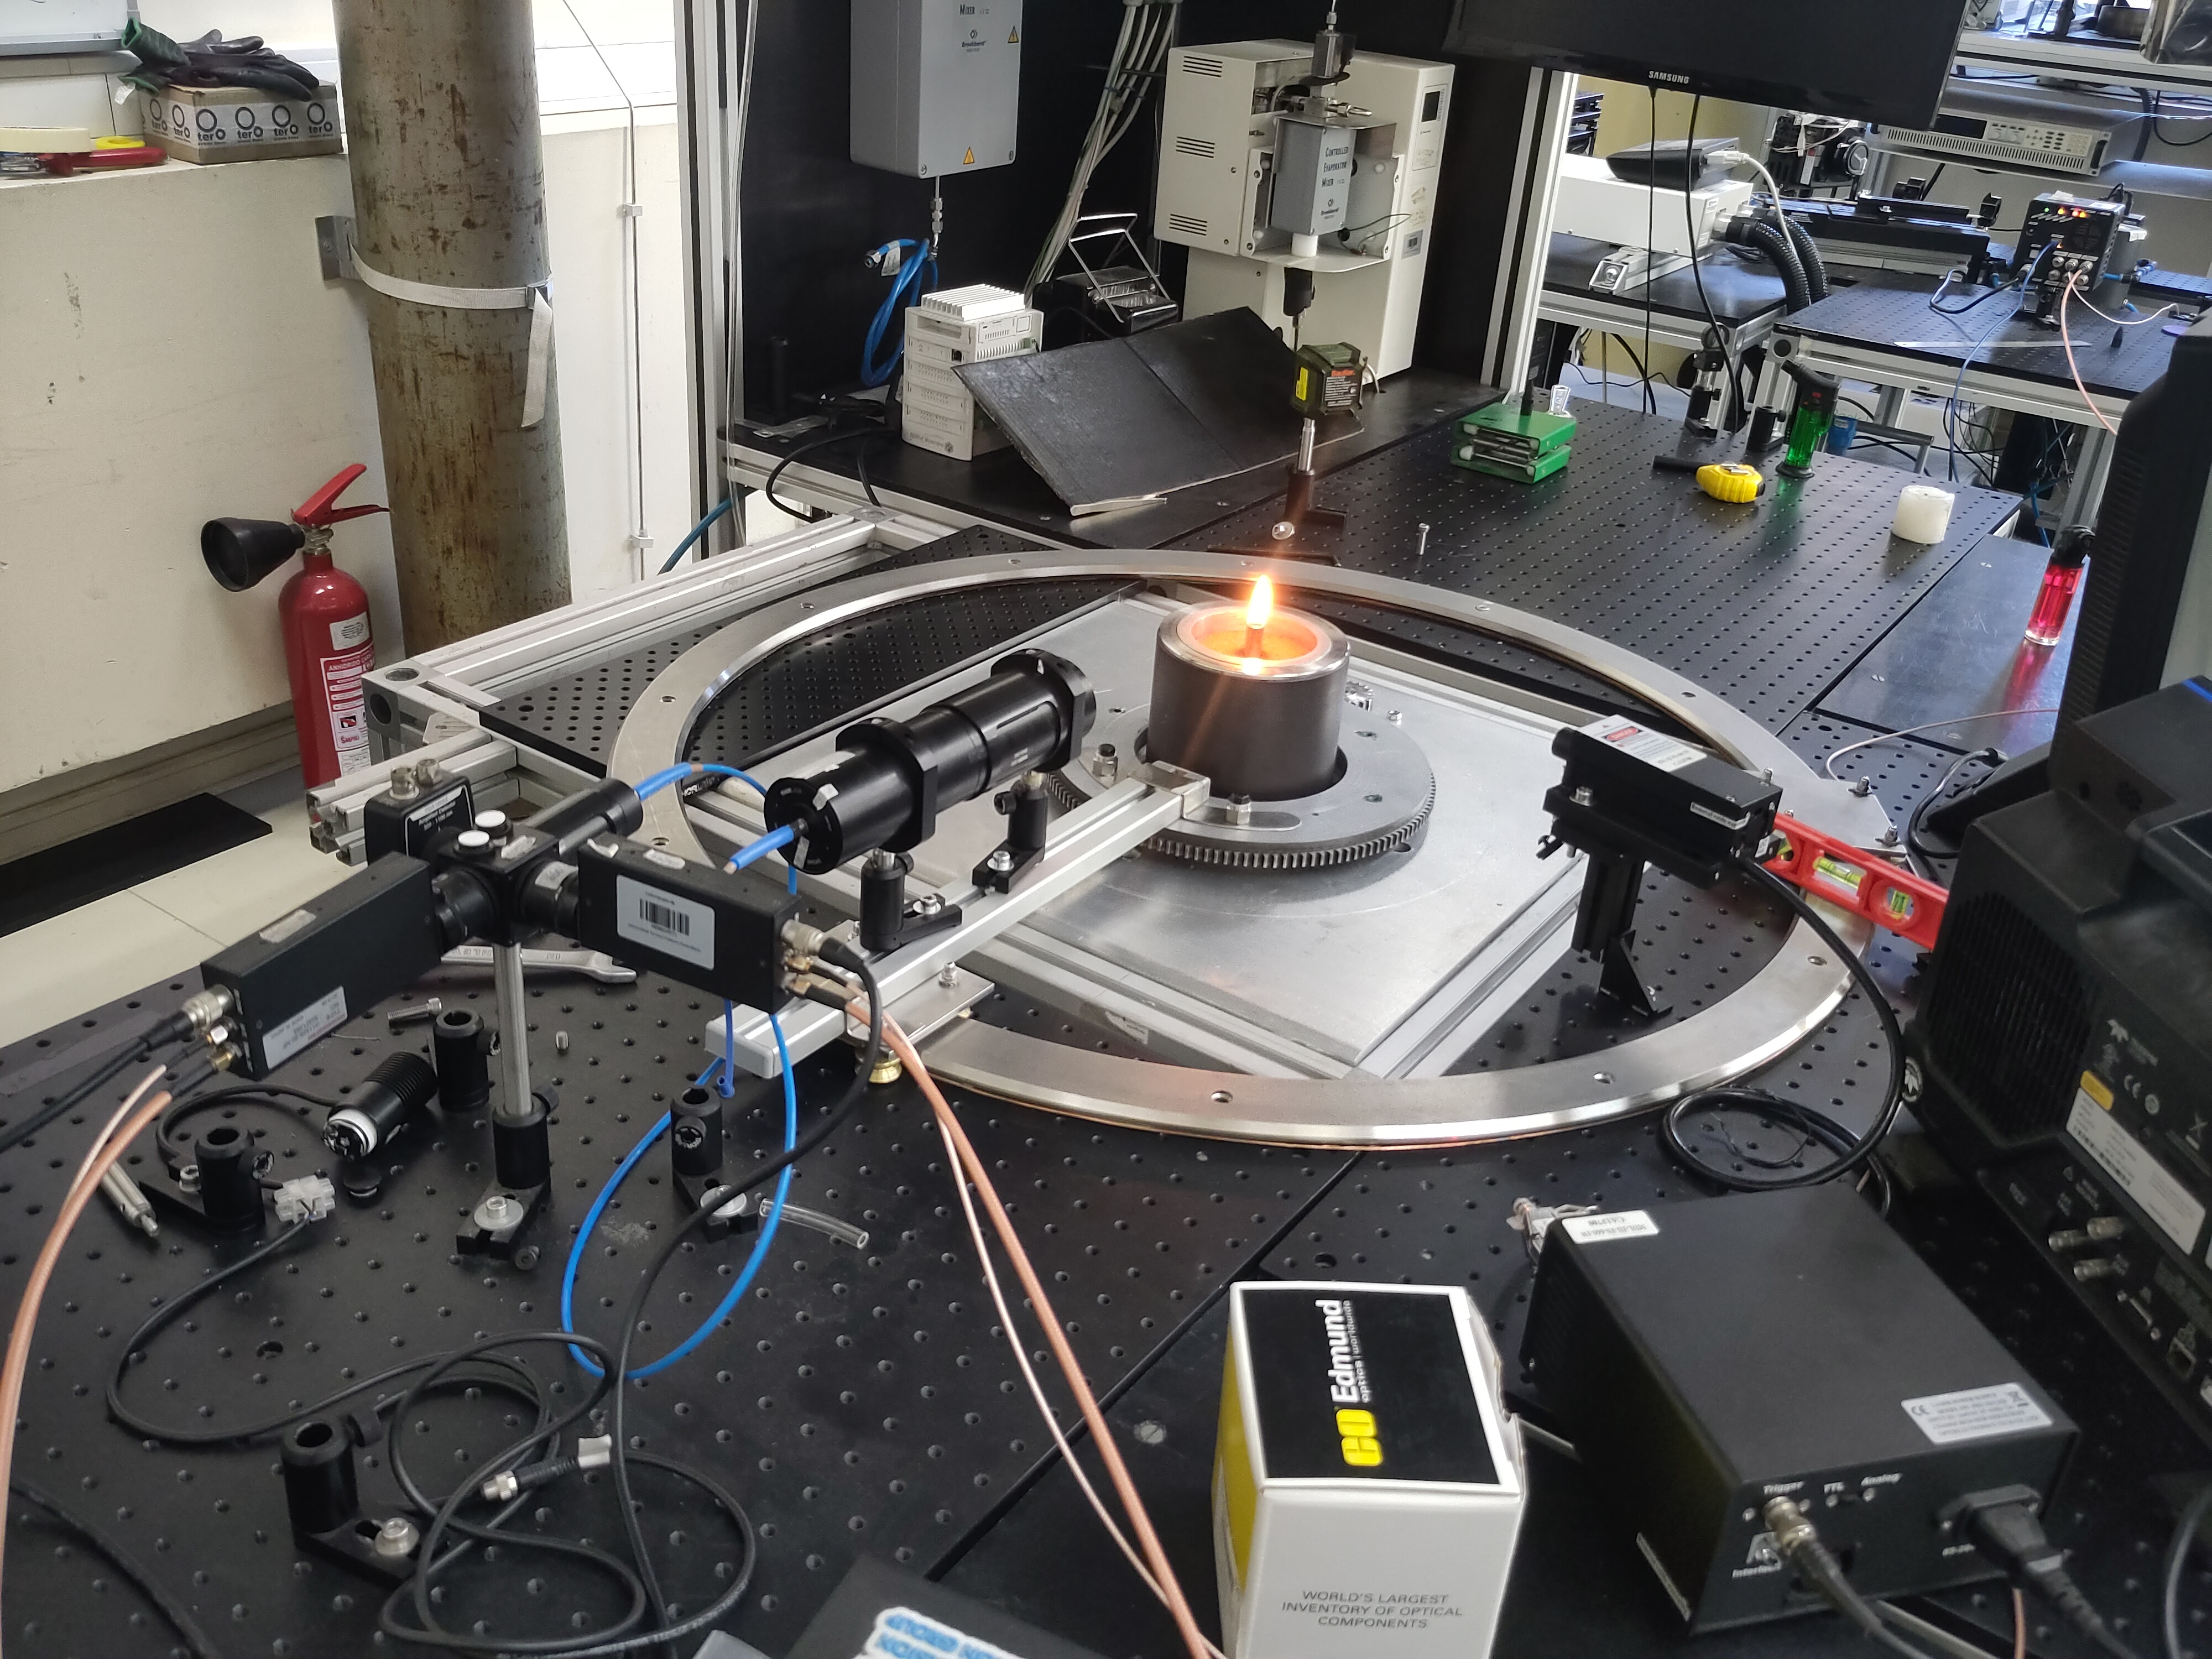

As shown in the article Yon et al. 2021 (see preparation document), the Gülder flame features radial and axial particle size distributions as in the following figure.

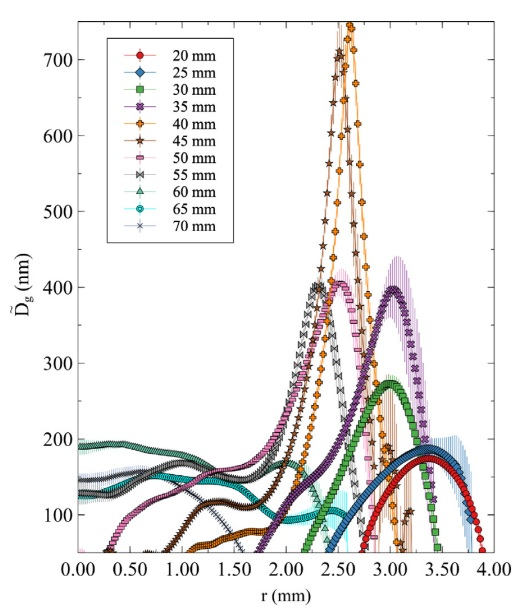

In the following, the code that you will be working on is presented step by step.

First, different environments and modules are imported, allowing to perform the following calculations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy import stats


This is followed by the definition of the arrays of measured values.
**WORK TO DO: Using a similar format as the vector of angles, add the vectors of your measured data.**

In [ ]:
Angle = np.arange(20, 131, 10)             # 20..130 deg
ScatAngle = 180.0 - Angle                  # scattering angle in degrees

# Four measured intensity sets (row vectors)
# ENTER THE ARRAYS OF THE MEASURED VALUES FOLLOWING THE FORMAT OF THE EXAMPLES BELOW
# Meas1 = np.array([69, 66, 59, 53, 50, 45, 42, 42, 43, 46, 52, 57], dtype=float)
Meas1 = np.array([,,,,,,,,,,,], dtype=float)
Meas2 = np.array([,,,,,,,,,,,], dtype=float)
Meas3 = np.array([,,,,,,,,,,,], dtype=float)
Meas4 = np.array([,,,,,,,,,,,], dtype=float)


In the following step, the data is pre-treated. Two points are done:


1.   The measured voltages are corrected for the fact, that no polariser is mounted in front of the detector. Indeed, the RDGFA equations are based on vertically polarised laser light, from which only the vertically polarised fraction is regarded (Kvv). For this pourpose, the data is multiplierd by 2*(1-cos(θ)^2) with \theta being the scattering angle relative to the optical axis of the laser beam.
2.   Finally, as the size can be retrieved directly by the structure factor f (which is smaller than 1), the measured voltages are normalised by a low angle value.





In [ ]:
Meas1a = Meas1 * 2.0 / (1.0 + np.cos(np.deg2rad(ScatAngle)) ** 2)
Meas2a = Meas2 * 2.0 / (1.0 + np.cos(np.deg2rad(ScatAngle)) ** 2)
Meas3a = Meas3 * 2.0 / (1.0 + np.cos(np.deg2rad(ScatAngle)) ** 2)
Meas4a = Meas4 * 2.0 / (1.0 + np.cos(np.deg2rad(ScatAngle)) ** 2)

Meas1b=Meas1a/Meas1a[-2]
Meas2b=Meas2a/Meas2a[-2]
Meas3b=Meas3a/Meas3a[-2]
Meas4b=Meas4a/Meas4a[-2]

Different parameters are fixed, in correspondance with typical values for soot found in the literature:


*   Dp: Primary sphere size in nm
*   kf: Franctal prefactor, associated with aggregate morphology
*   Df: Fractal dimension, also associate with aggregate morphology
*   λ : The laser wavelength, here 660nm





In [ ]:
Fm = 0.3                # volume fraction (or factor used in model)
Dp = 25e-9              # primary particle diameter (m)
kf = 2.2                # prefactor for Np_func
Df = 1.77               # fractal dimension used in model
Lambda = 660e-9         # wavelength (m)

Now different functions are defined, in accordance with RDGFA. **TASK: Enter the definition of the scattering wave vector q in the following function**

In [ ]:
def q_from_scatangle_deg(scatangle_deg):
    """Return q (1/m) from scattering angle in degrees and global Lambda."""
    theta_rad = np.deg2rad(scatangle_deg)
    return # ENTER THE FUNCTION HERE

**TASK: Enter the definition of the number of primary spheres per aggregate Np in the follwing function**

In [ ]:
def Np_func(Dg, Dp=Dp, kf=kf, Df=Df):
    """Number of primary particles in a fractal aggregate (model form)."""
    return # ENTER THE FUNCTION HERE

**TASK: Enter the definition of the dimensional size parameter xp in the following function**

In [ ]:
def xp_func(Dp=Dp, Lambda=Lambda):
    """Dimensionless size parameter xp = pi * Dp / Lambda."""
    return # ENTER THE FUNCTION HERE

We also define the wave number in the following function

In [ ]:
def k_func(Lambda=Lambda):
    """Wave number k = 2*pi / lambda."""
    return 2.0 * np.pi / Lambda

**TASK: Enter the definition of the structure factor f in the following function**

In [ ]:
def f_piecewise(q, Rg, Df=Df):
    """
    Piecewise function used in model:
    - Guinier-like region for small x = q*Rg (exponential)
    - Power-law region for large x (Df-dependent)
    This returns values consistent with the original script's piecewise form.
    """
    q = np.asarray(q, dtype=float)
    x = q * Rg
    threshold = np.sqrt(1.5 * Df)
    f = np.empty_like(x, dtype=float)

    # ENTER THE FUNCTION HERE

    return f

The data is preconditioned for fitting afterwards. This includes in particular the multiplication by sin(θ) in order to correct for the measurement volume that changes with observation angle and building the vector pairs (q;ConditionedMeasurements)

In [ ]:
def ConditionData(ScatAngle_deg, Meas):
    """
    Prepare conditioned dataset for fitting:
    - Compute q from ScatAngle_deg
    - Multiply Meas by sin(theta) (per original modified correction)
    - Extrapolate Meas_div vs q^2 to q=0 using the lowest 4 q points to estimate Meas0
      (Meas0 returned for potential use but not used in fit here)
    Returns: q, Meas_normalized (Meas*sin(theta)), Meas0
    """
    ScatAngle_deg = np.asarray(ScatAngle_deg)
    Meas = np.asarray(Meas, dtype=float)
    if ScatAngle_deg.shape != Meas.shape:
        raise ValueError("ScatAngle and Meas must have the same shape.")

    q = q_from_scatangle_deg(ScatAngle_deg)

    theta_rad = np.deg2rad(ScatAngle_deg)
    sin_theta = np.sin(theta_rad)
    # avoid exact zeros
    sin_theta[sin_theta == 0] = 1e-30

    # The conditioning used in original script multiplies by sin(theta)
    Meas_div = Meas * sin_theta

    # estimate intercept Meas0 by linear least-squares of y vs q^2 using lowest 4 q points
    #sort_idx = np.argsort(q)
    #q_sorted = q[sort_idx]
    #Meas_sorted = Meas_div[sort_idx]
    #n_fit = min(4, q_sorted.size)
    #q_fit = q_sorted[:n_fit]
    #y_fit = Meas_sorted[:n_fit]
    #A = np.vstack([np.ones_like(q_fit), q_fit ** 2]).T
    #coeffs, *_ = np.linalg.lstsq(A, y_fit, rcond=None)
    #Meas0 = coeffs[0]

    # if Meas0 is non-positive fallback to a small positive value
    #if Meas0 <= 0:
    #    Meas0 = np.max([1e-12, np.min(y_fit[y_fit > 0])]) if np.any(y_fit > 0) else 1.0

    # Note: original script computed Meas_normalized = Meas_div (did not divide by Meas0)
    Meas_normalized = Meas_div

    return q, Meas_normalized

**TASK: Call the conditioning function in order to obtain reconditioned data**

In [ ]:
q1, c1 = ConditionData(ScatAngle, Meas1b)
q2, c2 = ConditionData(ScatAngle, Meas2b)
q3, c3 = ConditionData(ScatAngle, Meas3b)
q4, c4 = ConditionData(ScatAngle, Meas4b)

The conditioned data is then concatenated in order to be plotted afterwards. Furthermore, a function is generated for helping to plot the functions in log-log scales, knowing that the fitting of the structure factor will also be done in log-log space.

In [ ]:
bigq = np.concatenate([q1, q2, q3, q4])
bigConditionData = np.concatenate([c1, c2, c3, c4])

# ---------------------------
# Small numeric helpers for logs
# ---------------------------
def safe_log(x, tiny=1e-20):
    """Natural log with a floor to avoid log(0) or log(neg)."""
    x = np.asarray(x, dtype=float)
    x[x <= 0] = tiny
    return np.log(x)

The raw data is then plotted in log-log scale

In [ ]:
# ---------------------------
# Plot raw measured intensities vs q (log-log)
# ---------------------------
def plot_raw_meas_vs_q_loglog(ScatAngle_deg, Meas_list, labels=None, title="Raw measured intensities vs q (log-log)"):
    """
    Plot the raw Meas arrays vs q on a log-log plot.
    Each Meas array must have the same length as ScatAngle_deg.
    """
    q = q_from_scatangle_deg(ScatAngle_deg)
    plt.figure(figsize=(8, 6))
    colors = ['C0', 'C1', 'C2', 'C3']
    for i, meas in enumerate(Meas_list):
        meas_plot = np.asarray(meas, dtype=float)
        meas_plot[meas_plot <= 0] = 1e-12  # ensure positive for log scale
        plt.scatter(q, meas_plot, color=colors[i % len(colors)], alpha=0.7, label=(labels[i] if labels else f"Meas{i+1}"))

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("q (1/m) [log]")
    plt.ylabel("Raw measured intensity [log]")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

# show the raw-data log-log plot using the polarization-corrected Meas?a arrays
plot_raw_meas_vs_q_loglog(ScatAngle, [Meas1b, Meas2b, Meas3b, Meas4b],
                          labels=["Meas1", "Meas2", "Meas3", "Meas4"])

In a second plot, the data is plotted together with their mean and error bars corresponding to the 95% confidence intervals obtained from the fact that multiple measurements are carried out. **TASK: Comment the error bars, different potential sources of error and suggest improvements in the experiment and the procedurs.**

In [ ]:
# ---------------------------
# Plot conditioned data and per-q means with 95% CI (log-log)
# ---------------------------
def plot_conditioned_means_loglog(q_angles, all_conditioneds, labels=None, title="Conditioned data (log-log)"):
    """
    Plot conditioned measurements (scatter), compute per-q means and 95% CI,
    and return means and CI for later overlay of fitted model.
    """
    plt.figure(figsize=(8, 6))
    colors = ['C0', 'C1', 'C2', 'C3']
    for i, arr in enumerate(all_conditioneds):
        plt.scatter(q_angles, arr, color=colors[i % len(colors)], alpha=0.6, label=(labels[i] if labels else f"Meas{i+1}"))

    # Compute per-q statistics (stack rows = measurement sets)
    stacked = np.vstack(all_conditioneds)
    means = np.mean(stacked, axis=0)
    stds = np.std(stacked, axis=0, ddof=1)
    n = stacked.shape[0]
    tval = stats.t.ppf(0.975, n - 1)
    sem = stds / np.sqrt(n)
    ci95 = tval * sem

    # Plot mean ±95% CI on log-log axes
    plt.errorbar(q_angles, means, yerr=ci95, fmt='o', color='black', ecolor='black',
                 elinewidth=1.5, capsize=4, markersize=7, markeredgewidth=1.2, label="mean ±95% CI")

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("q (1/m) [log]")
    plt.ylabel("Normalized intensity [log]")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    return means, ci95

q_angles = q1  # q arrays are identical across the four conditioned sets
means_before_fit, ci95_before = plot_conditioned_means_loglog(q_angles, [c1, c2, c3, c4],
                                                             labels=["Meas1", "Meas2", "Meas3", "Meas4"],
                                                             title="Conditioned data (log-log) and per-q means")


In the next step, the data is fitted by the structure factor f with the aim to find Rg*, the equivalent monodisperse gyration radius. **TASK: Note the monodisperse gyration radius of the soot particles and comment on the values. Try to identify different error sources in the experimental procedure and the thus obtained value.**

In [ ]:
# ---------------------------
# Fit Rg and amplitude A in log-space
# ---------------------------
def residuals_log(params, qdata, ydata):
    """
    Residuals in log-space: log(model) - log(data)
    params: [Rg, A], require both > 0
    """
    Rg, A = params
    if Rg <= 0 or A <= 0:
        # return large residuals to keep solver in bounds
        return 1e6 * np.ones_like(ydata)
    model = A * f_piecewise(qdata, Rg)
    return safe_log(model) - safe_log(ydata)

# initial guesses
Rg0 = 50e-9  # initial Rg guess (m)
A0 = 3.0     # initial amplitude guess
x0 = np.array([Rg0, A0])

# least-squares in log-space; bounds keep positive parameters
res = least_squares(residuals_log, x0, args=(bigq, bigConditionData),
                    bounds=([1e-12, 1e-12], [np.inf, np.inf]),
                    xtol=1e-12, ftol=1e-12)

Rg_fit, A_fit = res.x

print("Fitted parameters (log-space fit):")
print(f"  Rg = {Rg_fit:.6e} m = {Rg_fit*1e9:.3f} nm")
print(f"  A  = {A_fit:.6e}")

# Estimate parameter uncertainties where possible using jacobian
J = res.jac
dof = bigq.size - x0.size
if dof > 0:
    residual_var = 2 * res.cost / dof
    try:
        cov = np.linalg.inv(J.T.dot(J)) * residual_var
        perr = np.sqrt(np.abs(np.diag(cov)))
        print("Parameter uncertainties (approx. 1-sigma):")
        print(f"  dRg = {perr[0]:.3e} m = {perr[0]*1e9:.3f} nm")
        print(f"  dA  = {perr[1]:.3e}")
    except np.linalg.LinAlgError:
        print("Could not estimate parameter uncertainties (singular J^T J).")
else:
    print("Not enough degrees of freedom to estimate parameter uncertainties.")


Finally, the measured reconditioned data plots are overlaid with the structure factor f, calculated for your retreived particle gyration radius Rg*

In [ ]:
# ---------------------------
# Final overlay plot: conditioned means + fitted model (log-log)
# ---------------------------
plt.figure(figsize=(8, 6))
for i, arr in enumerate([c1, c2, c3, c4]):
    plt.scatter(q_angles, arr, color=f"C{i}", alpha=0.35)

# plot mean ±95% CI again
stacked = np.vstack([c1, c2, c3, c4])
means = np.mean(stacked, axis=0)
stds = np.std(stacked, axis=0, ddof=1)
n = stacked.shape[0]
tval = stats.t.ppf(0.975, n - 1)
ci95 = tval * (stds / np.sqrt(n))
plt.errorbar(q_angles, means, yerr=ci95, fmt='o', color='black', ecolor='black',
             elinewidth=1.5, capsize=4, markersize=7, markeredgewidth=1.2, label="mean ±95% CI")

# smooth q to plot the fitted curve
q_smooth = np.logspace(np.log10(np.min(q_angles) * 0.98), np.log10(np.max(q_angles) * 1.02), 300)
f_fit = A_fit * f_piecewise(q_smooth, Rg_fit)
plt.plot(q_smooth, f_fit, '-', color='red', lw=2, label=f"Fitted model (Rg={Rg_fit*1e9:.2f} nm)")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("q (1/m) [log]")
plt.ylabel("Normalized intensity [log]")
plt.title("Per-q means with 95% CI and fitted model (log-log)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()